In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print(os.listdir('/kaggle/input/histopathologic-cancer-detection/train')[:5])

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']


In [3]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

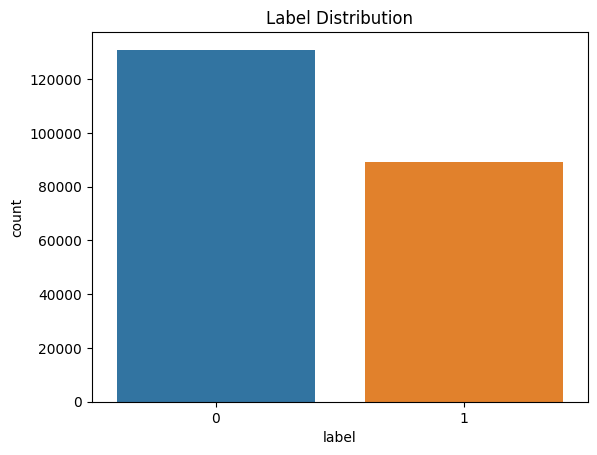

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting label distribution
sns.countplot(x='label', data=labels)
plt.title("Label Distribution")
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to display a few images
def display_sample_images(label, n=5):
    samples = labels[labels['label'] == label].sample(n=n, random_state=42)
    plt.figure(figsize=(10, 5))
    for i, image_id in enumerate(samples['id']):
        img_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', image_id + '.tif')
        img = load_img(img_path, target_size=(96, 96))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images for Label: {label}')
    plt.show()

2024-08-12 21:41:56.867379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 21:41:56.867490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 21:41:57.002111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


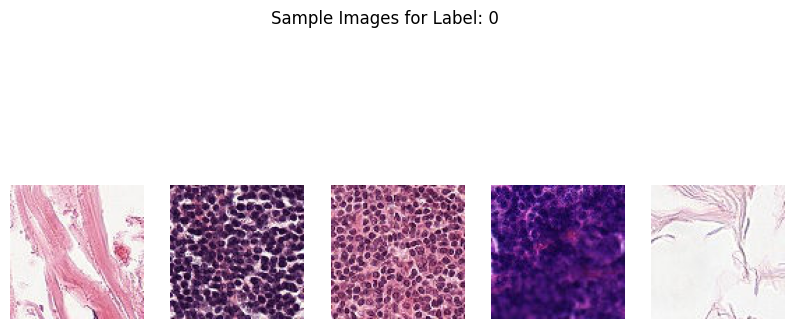

In [8]:
# Display sample images for each class
display_sample_images(label=0)  # Non-Cancerous

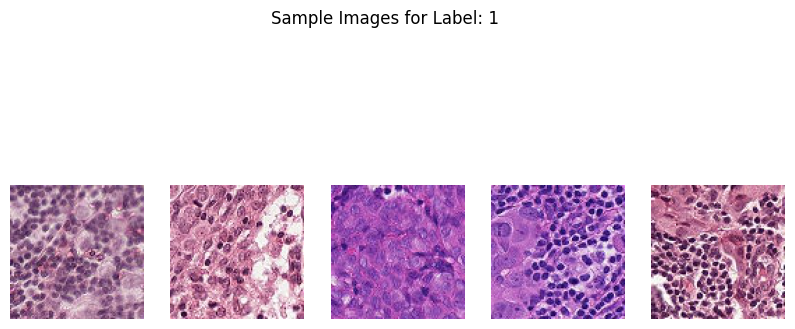

In [9]:
display_sample_images(label=1)  # Cancerous

In [10]:
# Load a small sample of images to analyze pixel intensity distributions
sample_images = labels.sample(n=100, random_state=42)
images = []

for image_id in sample_images['id']:
    img_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', image_id + '.tif')
    img = load_img(img_path, target_size=(96, 96))
    img = np.array(img)
    images.append(img)

images = np.array(images)

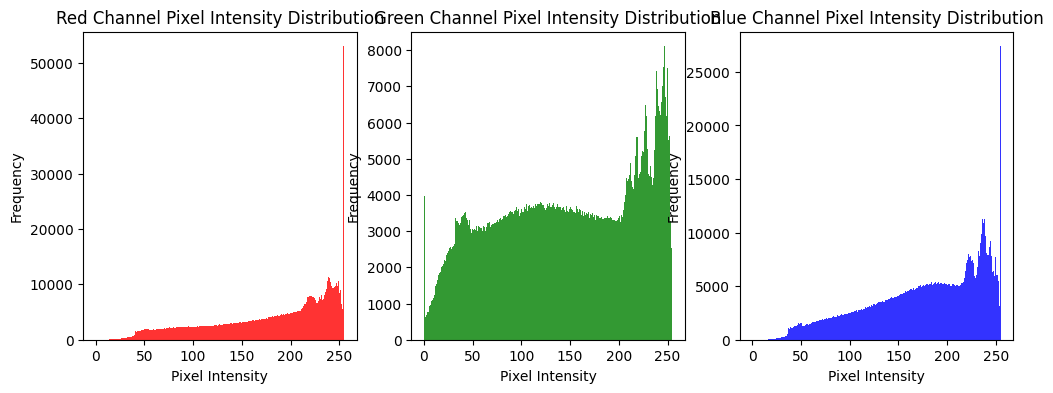

In [11]:
# Plot the pixel intensity distribution for each color channel
plt.figure(figsize=(12, 4))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1, 3, i + 1)
    plt.hist(images[:, :, :, i].ravel(), bins=256, color=color.lower(), alpha=0.8)
    plt.title(f'{color} Channel Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
plt.show()

In [12]:
missing_files = labels[~labels['id'].apply(lambda x: x + '.tif').isin(os.listdir('/kaggle/input/histopathologic-cancer-detection/train'))]
print(f"Number of files listed in DataFrame but missing in directory after correction: {len(missing_files)}")

Number of files listed in DataFrame but missing in directory after correction: 0


In [13]:
from sklearn.model_selection import train_test_split

# Convert labels to string format (if necessary) for compatibility with ImageDataGenerator
labels['label'] = labels['label'].astype(str)

# If necessary, append the '.tif' extension to the IDs in the DataFrame
labels['id'] = labels['id'].apply(lambda x: x + '.tif')

# Split the data into training and validation sets
train_ids, val_ids, y_train, y_val = train_test_split(
    labels['id'], labels['label'], test_size=0.2, random_state=42
)

print(f"Number of training samples: {len(train_ids)}")
print(f"Number of validation samples: {len(val_ids)}")

Number of training samples: 176020
Number of validation samples: 44005


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to the range [0, 1]
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,    # Randomly flip images vertically
    rotation_range=20,     # Randomly rotate images within a range of 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    validation_split=0.2    # Reserve a portion of data for validation (already handled above)
)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels[labels['id'].isin(train_ids)],
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=labels[labels['id'].isin(val_ids)],
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [16]:
def create_baseline_model(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = baseline_model.fit(
    train_generator,
    epochs=3, # Chose a low value for epochs to decrease training time of model
    validation_data=val_generator
)

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-12 21:47:23.581507: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.17839, expected 5.44963
2024-08-12 21:47:23.581562: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 5.09095, expected 4.36218
2024-08-12 21:47:23.581571: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8843: 6.28436, expected 5.55559
2024-08-12 21:47:23.581579: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.83888, expected 5.11011
2024-08-12 21:47:23.581587: E external/local_xla/xla/service/gpu/buffer_comp

   1/5501 ━━━━━━━━━━━━━━━━━━━━ 11:40:00 8s/step - accuracy: 0.5312 - loss: 0.6779

I0000 00:00:1723499246.323698     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 269/5501 ━━━━━━━━━━━━━━━━━━━━ 19:00 218ms/step - accuracy: 0.5768 - loss: 0.9339

2024-08-12 21:48:25.800078: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44180: 7.15656, expected 6.24082
2024-08-12 21:48:25.800146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44181: 8.03765, expected 7.12192
2024-08-12 21:48:25.800162: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44182: 7.32376, expected 6.40803
2024-08-12 21:48:25.800182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44183: 6.00329, expected 5.08755
2024-08-12 21:48:25.800194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44184: 6.93475, expected 6.01901
2024-08-12 21:48:25.800207: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44185: 7.6303, expected 6.71456
2024-08-12 21:48:25.800219: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44186: 7.59534, expected 6.6796
2024-08-12 21:48:25.800231: E

5494/5501 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.5931 - loss: 0.6985

2024-08-12 22:15:46.820382: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44180: 8.02016, expected 7.07077
2024-08-12 22:15:46.820450: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44182: 7.26606, expected 6.31667
2024-08-12 22:15:46.820460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44183: 7.47131, expected 6.52192
2024-08-12 22:15:46.820468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44184: 7.1578, expected 6.20841
2024-08-12 22:15:46.820476: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44185: 8.13563, expected 7.18624
2024-08-12 22:15:46.820484: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44186: 8.38974, expected 7.44035
2024-08-12 22:15:46.820492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44187: 8.28349, expected 7.3341
2024-08-12 22:15:46.820499: E

5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1709s 309ms/step - accuracy: 0.5931 - loss: 0.6985 - val_accuracy: 0.5949 - val_loss: 0.6750
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 953s 173ms/step - accuracy: 0.5956 - loss: 0.6748 - val_accuracy: 0.5949 - val_loss: 0.6751
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 913s 166ms/step - accuracy: 0.5943 - loss: 0.6753 - val_accuracy: 0.5949 - val_loss: 0.6751


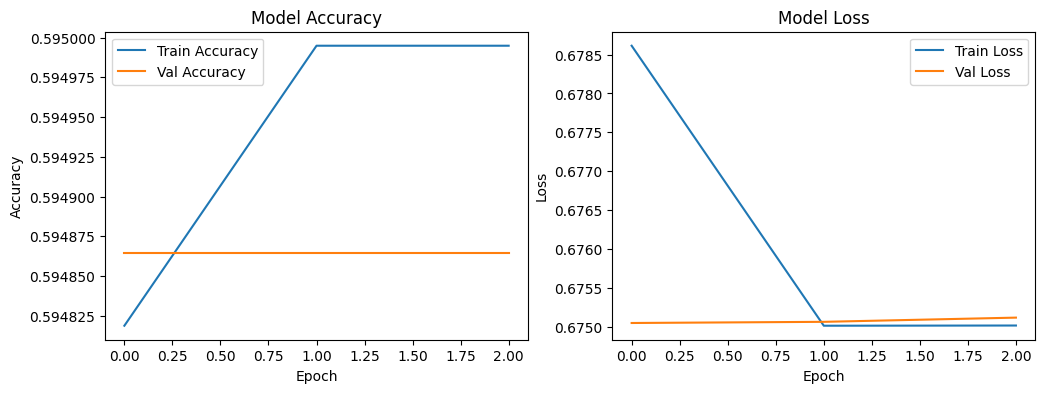

In [18]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [19]:
# More Epochs would increase accuracy and decrease loss, but also increase the time it takes.

In [36]:
def create_baseline_model_v2(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),  # Increase filters in the first layer
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),  # Increase filters in the second layer
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),  # Increase units in the dense layer
        Dropout(0.3),  # Reduce dropout rate
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])  # Slightly higher learning rate
    return model

baseline_model_v2 = create_baseline_model_v2()
baseline_model_v2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,935,873 (60.79 MB)

 Trainable params: 15,935,873 (60.79 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history_baseline_v2 = baseline_model_v2.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 966s 175ms/step - accuracy: 0.5901 - loss: 0.7487 - val_accuracy: 0.5949 - val_loss: 0.6750
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 942s 171ms/step - accuracy: 0.5960 - loss: 0.6747 - val_accuracy: 0.5949 - val_loss: 0.6750
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 894s 162ms/step - accuracy: 0.5949 - loss: 0.6864 - val_accuracy: 0.5949 - val_loss: 0.6750


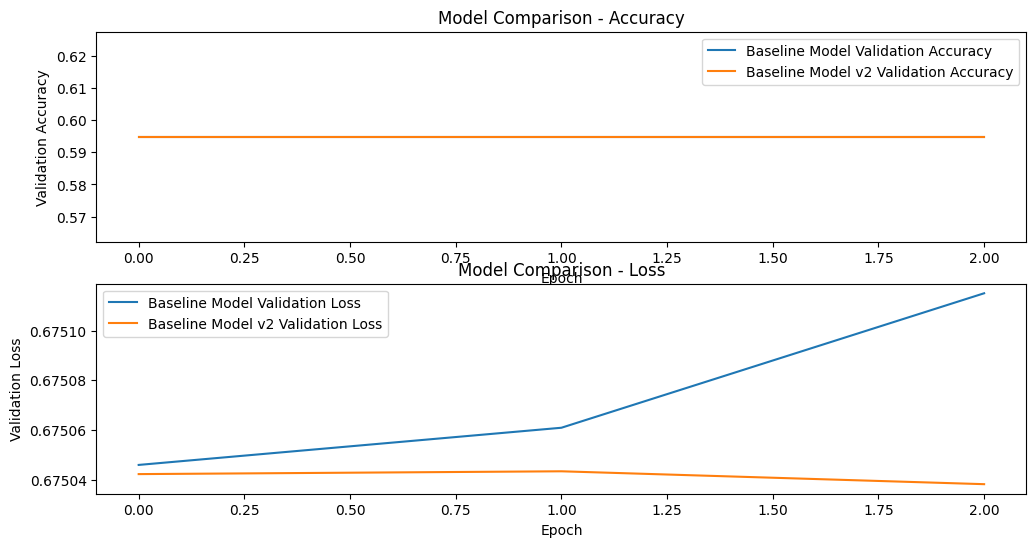

In [39]:
import matplotlib.pyplot as plt

def plot_comparison(histories, labels, title="Model Comparison"):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()

    plt.show()

# Compare the two models
plot_comparison([history, history_baseline_v2], ['Baseline Model', 'Baseline Model v2'])

In [42]:
import pandas as pd

# Get the final validation accuracy and loss for each model
results = {
    'Model': ['Baseline Model', 'Baseline Model v2'],
    'Validation Accuracy': [
        history.history['val_accuracy'][-1],
        history_baseline_v2.history['val_accuracy'][-1]
    ],
    'Validation Loss': [
        history.history['val_loss'][-1],
        history_baseline_v2.history['val_loss'][-1]
    ]
}

# Create a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print(results_df)


               Model  Validation Accuracy  Validation Loss
0     Baseline Model             0.594864         0.675115
1  Baseline Model v2             0.594864         0.675038


The models have the same accuracy after 3 epochs, however the loss for the second model is lower. This is because of the higher learning rate and increased filtration and units in the dense layer.

In [43]:
# Directory where test images are stored
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

In [44]:
# Load the test data
test_filenames = os.listdir(test_dir)
test_ids = [filename.split('.')[0] for filename in test_filenames]

In [45]:
# Function to load test images
def load_test_images(test_ids, directory, target_size=(96, 96)):
    images = []
    for image_id in test_ids:
        img_path = os.path.join(directory, image_id + '.tif')
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize the image
        images.append(img_array)
    return np.array(images)

In [46]:
# Load all test images
X_test = load_test_images(test_ids, test_dir)

In [47]:
# Make predictions on the test data using the best model
predictions = baseline_model_v2.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
predictions = (predictions > 0.5).astype(int).flatten()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [48]:
# Create a DataFrame with the predictions
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': predictions
})

# Save the DataFrame as a CSV file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)